# Housekeeping

In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
timespan = 100000000

# Data Gathering, Generating Features, Creating Train-Test Split

In [70]:

def get_data():
    Vol_Index = yf.download("^VIX", auto_adjust=True, period='max')["Close"]
    SPY = yf.download("SPY", auto_adjust=True, period='max')["Close"]
    SH = yf.download("SH", auto_adjust=True, period='max')["Close"]  # Add SH data
    VolVol_Index = yf.download("^VVIX", auto_adjust=True, period='max')["Close"]
    TenYearTNote = yf.download("^TNX", auto_adjust=True, period='max')["Close"]

    df = pd.concat([Vol_Index, SPY, SH, VolVol_Index, TenYearTNote], axis=1)
    df.columns = ['Vol_Index', 'SPY', 'SH', 'VolVol_Index', 'TenYearTNote']
    df = df.iloc[-timespan:]
    return df.dropna()


def get_features(df):
    # Daily Returns
    df['VIX_ret_1d'] = df['Vol_Index'].pct_change()
    df['SPY_ret_1d'] = df['SPY'].pct_change()
    df['SH_ret_1d'] = df['SH'].pct_change()  # Add SH return

    # Technical Indicators for VIX
    df['VIX_SMA20'] = df['Vol_Index'].rolling(20).mean() #Indicates if VIX is elevated or depressed
    df['VIX_ratio'] = df['Vol_Index'] / df['VIX_SMA20'] #Suggests that VIX might be high compared to recent history if greater than 1 
    df['VIX_std20'] = df['Vol_Index'].rolling(20).std() #Measures the volatility of its volatility, higher values might imply whether VIX is unstable or erratic

    # Spread Features
    df['VIX_VVIX_spread'] = df['Vol_Index'] - df['VolVol_Index']  #Spread between VIX and VVIX, larger spread often precedes spikes in market fear
    df['TNX_ret_1d'] = df['TenYearTNote'].pct_change()  #10yr treasury yield return - Captures Macro Sentiment 

    # Will VIX Rise Tomorrow?
    df['VIX_direction'] = (df['Vol_Index'].shift(-1) > df['Vol_Index']).astype(int) #Predicting whether VIX will increase using other features

    return df.dropna()


def get_features_train_test_split(df):
    features = ['VIX_ret_1d', 'SPY_ret_1d', 'VIX_ratio', 'VIX_std20', 'VIX_VVIX_spread', 'TNX_ret_1d']
    input_data = df[features].dropna()  # Prepare input features and drop missing values
    target_variable = df.loc[input_data.index, 'VIX_direction']  # What are we trying to predict?
    
 
    X_train, X_test, y_train, y_test = train_test_split(input_data, target_variable, train_size=0.75, shuffle=False)
    
    return X_train, X_test, y_train, y_test


# Training Model, Summarising Performance 

In [71]:
def train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_proba 

def model_performance_summary(y_test, y_pred):
    print("=== Model Classification Report ===")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    report = classification_report(y_test, y_pred, output_dict=True)
    print("=== Model Classification Summary ===")
    
    accuracy = report['accuracy']
    print(f"• The model predicts the target variable with an overall accuracy of {accuracy:.2%}.\n")
    
    for cls in sorted(report.keys()):
        if cls in ['accuracy', 'macro avg', 'weighted avg']:
            continue

        precision = report[cls]['precision']
        recall = report[cls]['recall']
        f1 = report[cls]['f1-score']
        support = report[cls]['support']

        if cls == '0':
            print("• For class '0' (VIX does **not** rise the next day):")
            print(f"  - Precision: {precision:.2%} → Of all predictions that VIX would stay flat or fall, this % were correct.")
            print(f"  - Recall: {recall:.2%} → The model correctly identified this % of actual 'no-rise' days.")
            print(f"  - F1-score: {f1:.2%} → Balance between precision and recall for predicting no VIX rise.")
        elif cls == '1':
            print("• For class '1' (VIX **rises** the next day):")
            print(f"  - Precision: {precision:.2%} → Of all predictions that VIX would rise, this % were correct.")
            print(f"  - Recall: {recall:.2%} → The model correctly captured this % of actual VIX rise events.")
            print(f"  - F1-score: {f1:.2%} → Balance between precision and recall for predicting VIX rises.")

        print(f"  - Based on {support} samples for this class.\n")

# Calibrating to Find the Optimal Strategy

In [72]:
def find_best_threshold(df, X_test, y_proba):
    df = df.copy()
    df['SPY_ret_1d'] = df['SPY'].pct_change()
    thresholds = np.arange(0.3, 0.6, 0.025)
    returns = []

    for t in thresholds:
        df['position'] = 0
        df.loc[X_test.index, 'position'] = np.where(y_proba > t, 1, -1)
        df['strategy_ret'] = df['position'].shift(1) * df['SPY_ret_1d']
        cumulative = (1 + df['strategy_ret']).cumprod()
        final_return = cumulative.dropna().iloc[-1]
        returns.append(final_return)
        print(f"Threshold: {t:.3f} → Final return: {final_return:.4f}")

    plt.figure(figsize=(10, 2))
    sns.heatmap([returns], xticklabels=[f"{th:.3f}" for th in thresholds], cmap="RdYlGn", annot=True, fmt=".4f")
    plt.title("Final Strategy Returns by Threshold")
    plt.xlabel("Threshold")
    plt.yticks([], [])  # Hide y-axis labels since only one row
    plt.show()

    best_idx = np.argmax(returns)
    best_threshold = thresholds[best_idx]
    print(f"\nBest threshold found: {best_threshold:.3f} with final return {returns[best_idx]:.4f}\n")
    return best_threshold

def backtest_strategy(df, X_test, y_proba, threshold):
    df = df.copy()
    df['SPY_ret'] = df['SPY'].pct_change()

    # Only start from when strategy starts
    start_date = X_test.index[0]
    df = df.loc[start_date:]

    # Strategy Position: long SPY if VIX predicted to rise, else short
    df['position'] = 0
    df.loc[X_test.index, 'position'] = np.where(y_proba > threshold, 1, -1)

    # Strategy Returns
    df['strategy_ret'] = df['position'].shift(1) * df['SPY_ret']
    df['cumulative_strategy'] = (1 + df['strategy_ret']).cumprod()

    # SPY Buy & Hold returns (starting from same date as strategy)
    df['cumulative_spy'] = (1 + df['SPY_ret']).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['cumulative_strategy'], label='Strategy', linewidth=2)
    plt.plot(df['cumulative_spy'], label='SPY (Buy & Hold)', linewidth=2)
    
    plt.title(f"Cumulative Returns: Strategy vs SPY (Threshold = {threshold:.3f})", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative Return", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df

# Summarising Performance, Running Code

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=== Model Classification Report ===
              precision    recall  f1-score   support

           0       0.60      0.78      0.68       659
           1       0.52      0.31      0.39       501

    accuracy                           0.58      1160
   macro avg       0.56      0.55      0.53      1160
weighted avg       0.57      0.58      0.55      1160



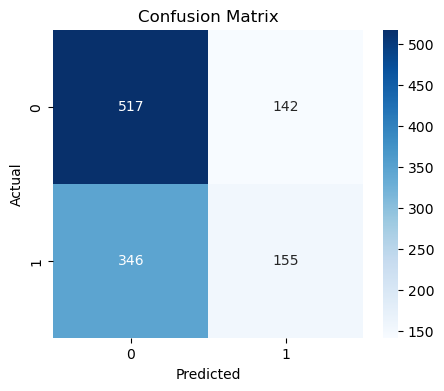

=== Model Classification Summary ===
• The model predicts the target variable with an overall accuracy of 57.93%.

• For class '0' (VIX does **not** rise the next day):
  - Precision: 59.91% → Of all predictions that VIX would stay flat or fall, this % were correct.
  - Recall: 78.45% → The model correctly identified this % of actual 'no-rise' days.
  - F1-score: 67.94% → Balance between precision and recall for predicting no VIX rise.
  - Based on 659.0 samples for this class.

• For class '1' (VIX **rises** the next day):
  - Precision: 52.19% → Of all predictions that VIX would rise, this % were correct.
  - Recall: 30.94% → The model correctly captured this % of actual VIX rise events.
  - F1-score: 38.85% → Balance between precision and recall for predicting VIX rises.
  - Based on 501.0 samples for this class.

Threshold: 0.300 → Final return: 2.1307
Threshold: 0.325 → Final return: 1.9893
Threshold: 0.350 → Final return: 1.5183
Threshold: 0.375 → Final return: 1.3599
Threshold: 

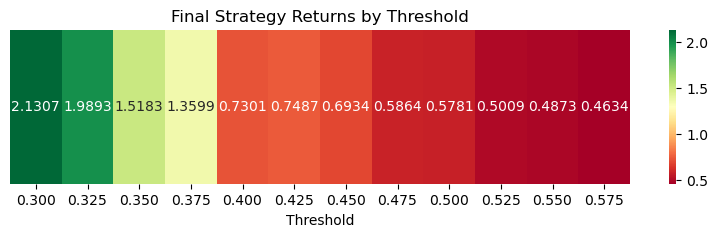


Best threshold found: 0.300 with final return 2.1307

Backtesting with best threshold 0.300:


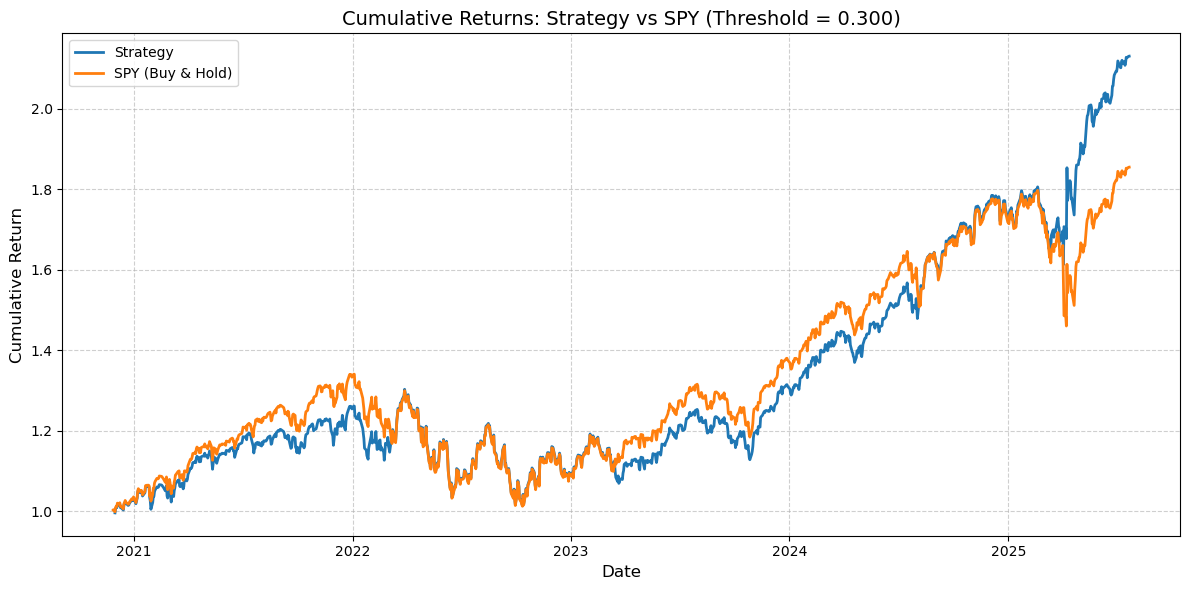

=== Strategy Performance Summary ===
Total Return: 113.07%
Annualized Return (CAGR): 17.88%
Sharpe Ratio (annualized): 1.03
Max Drawdown: -22.09%

SPY Total Return (Buy & Hold): 85.49%
SPY Annualized Return (CAGR): 14.38%
SPY Sharpe Ratio (annualized): 0.85
SPY Max Drawdown: -24.50%


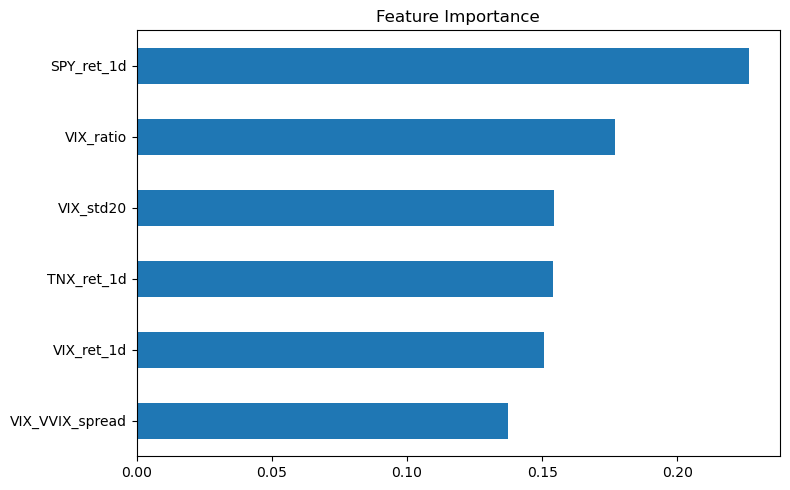

In [73]:
def strategy_performance_summary(df):
   
    cumulative_return = df['cumulative_strategy'].iloc[-1] - 1
    total_days = len(df.dropna())
    annual_factor = 252  # trading days/year
    annualized_return = (df['cumulative_strategy'].iloc[-1]) ** (annual_factor / total_days) - 1
    strat_ret = df['strategy_ret'].dropna()

    # Sharpe Ratio (assuming risk-free rate = 0)
    sharpe_ratio = strat_ret.mean() / strat_ret.std() * np.sqrt(annual_factor)

    # Max Drawdown
    running_max = df['cumulative_strategy'].cummax()
    drawdown = (df['cumulative_strategy'] - running_max) / running_max
    max_drawdown = drawdown.min()

    #SPY Figures
    spy_return = df['cumulative_spy'].iloc[-1] - 1
    spy_cagr = df['cumulative_spy'].iloc[-1] ** (annual_factor / total_days) - 1
    spy_ret = df['SPY'].pct_change()
    spy_sharpe = spy_ret.mean() / spy_ret.std() * np.sqrt(252)

    spy_running_max = df['cumulative_spy'].cummax()
    spy_drawdown = (df['cumulative_spy'] - spy_running_max) / spy_running_max
    spy_max_drawdown = spy_drawdown.min()

    print("=== Strategy Performance Summary ===")
    print(f"Total Return: {cumulative_return*100:.2f}%")
    print(f"Annualized Return (CAGR): {annualized_return*100:.2f}%")
    print(f"Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    print()
    print(f"SPY Total Return (Buy & Hold): {spy_return*100:.2f}%")
    print(f"SPY Annualized Return (CAGR): {spy_cagr*100:.2f}%")
    print(f"SPY Sharpe Ratio (annualized): {spy_sharpe:.2f}")
    print(f"SPY Max Drawdown: {spy_max_drawdown*100:.2f}%")



def plot_feature_importance(model, features):
    importances = pd.Series(model.feature_importances_, index=features)
    importances.sort_values().plot(kind='barh', title='Feature Importance', figsize=(8, 5))
    plt.tight_layout()
    plt.show()


def main():
    df = get_data()
    df = get_features(df)

    X_train, X_test, y_train, y_test = get_features_train_test_split(df)

    model = train_model(X_train, y_train)
    

    y_pred, y_proba = evaluate_model(model, X_test, y_test)
    model_performance_summary(y_test, y_pred)
    
    best_thresh = find_best_threshold(df.copy(), X_test, y_proba)

    print(f"Backtesting with best threshold {best_thresh:.3f}:")
    df_backtest = backtest_strategy(df.copy(), X_test, y_proba, best_thresh)

    strategy_performance_summary(df_backtest)

    plot_feature_importance(model, X_train.columns)
main()